# COSMOS2020 catalogue analysis 

by D. Blanquez, I. Davidzon, G. Magdis

Contacts: dblse@space.dtu.dk

With the present Notebook the user is able to extract valuable information from the COSMOS2020 catalogue, which can be downloaded from [this data repository](https://cosmos2020.calet.org/). This is also a convenient starting point for further analysis. With minimal modifications the code can be useful to study others galaxy catalogues. 

The Notebook is divided in the following sections:

* **Introduction**: loading the tables and selecting the columns
* **Data preparation**: basic manipulations/corrections of the original photometry
* **Data visualization**: sky map, redshift and color distributions, SED fitting
* **Classic diagnostics**: color-color diagrams, SFR vs. M* diagram, ...
* **A simple machine-learning application**: prducing "mock photometry" by means of Gaussian Mixtures

Acknowledgments: if you use the COSMOS2020 catalog in your study, please cite [Weaver et al. (2021)](https://arxiv.org/abs/2110.13923)

In [1]:
%matplotlib inline 
import numpy as np 
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table
from astropy.cosmology import Planck15,FlatLambdaCDM

# For ML application
from sklearn.cluster import KMeans
from sklearn import mixture
from itertools import combinations


## Introduction: the COSMOS2020 catalogue in two complementary versions

There are two versions of the COSMOS2020 catalogue: a *Classic* one where the photometry is produced by a pipeline similar to Laigle et al. (2016), and the *Farmer* version that relies on the software *Tractor* recently developed by Lang & Hogg (http://thetractor.org/). Respective file names are:

1. COSMOS2020_CLASSIC_R1_v2.0.fits
2. COSMOS2020_FARMER_R1_v2.0.fits

Both tables come with additional information from SED fitting anlaysis (photometric redshifts, stellar masses, etc.) and a `*.header` ASCII file explaining the content of each column. Depending on the version some column may have a slightly different name. Please note that SED fitting was performed twice, with eather *LePhare* or *EAZY* code. Therefore, there are four possible combinations to do science: *Farmer* + *LePhare*, *Farmer* + *EAZY*, etc. 

These and many more input parameters are specified in the present section.

In [7]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/path/to/the/cosmos2020/catalogs/'  
dir_out = './'  # the directory where the output of this notebook will be stored

In [8]:
# Chose the SED fitting code: 
# set to 'lp' for LePhare results or
# set to 'ez' for EAZY
fitversion = 'lp'  

In [9]:
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'

There are several pararemeters regarding the telescope filters used for observations. They are collectively stored in a dictionary. 

In [10]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

--------------------
## Data preparation

This section includes corrections due to Milky Way foreground extinction, photometric offsets, and flux loss in case of aperture photometry. Here, a subsample of the catalogue (either by rows or columns) can also be selected, and the table re-formatted to be saved as a different file.

In [11]:
# Upload the main catalogue
cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.0.fits'.format(catversion.upper()),format='fits',hdu=1)

In [12]:
# Create a mask to restrict the analysis to a subset of filters (optional)
filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']
filt_mask = [i in filt_use for i in filt_name]

In [13]:
# Have a quick look inside the table
cat0[[0,-1]]

ID,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLUX_RADIUS,KRON_RADIUS,FLAG_HSC,FLAG_SUPCAM,FLAG_UVISTA,FLAG_UDEEP,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX_APER2,CFHT_u_FLUXERR_APER2,CFHT_u_FLUX_APER3,CFHT_u_FLUXERR_APER3,CFHT_u_FLUX_AUTO,CFHT_u_FLUXERR_AUTO,CFHT_u_MAG_APER2,CFHT_u_MAGERR_APER2,CFHT_u_MAG_APER3,CFHT_u_MAGERR_APER3,CFHT_u_MAG_AUTO,CFHT_u_MAGERR_AUTO,CFHT_u_MAG_ISO,CFHT_u_MAGERR_ISO,CFHT_u_FLAGS,CFHT_u_IMAFLAGS_ISO,CFHT_ustar_FLUX_APER2,CFHT_ustar_FLUXERR_APER2,CFHT_ustar_FLUX_APER3,CFHT_ustar_FLUXERR_APER3,CFHT_ustar_FLUX_AUTO,CFHT_ustar_FLUXERR_AUTO,CFHT_ustar_MAG_APER2,CFHT_ustar_MAGERR_APER2,CFHT_ustar_MAG_APER3,CFHT_ustar_MAGERR_APER3,CFHT_ustar_MAG_AUTO,CFHT_ustar_MAGERR_AUTO,CFHT_ustar_MAG_ISO,CFHT_ustar_MAGERR_ISO,CFHT_ustar_FLAGS,CFHT_ustar_IMAFLAGS_ISO,HSC_g_FLUX_APER2,HSC_g_FLUXERR_APER2,HSC_g_FLUX_APER3,HSC_g_FLUXERR_APER3,HSC_g_FLUX_AUTO,HSC_g_FLUXERR_AUTO,HSC_g_MAG_APER2,HSC_g_MAGERR_APER2,HSC_g_MAG_APER3,HSC_g_MAGERR_APER3,HSC_g_MAG_AUTO,HSC_g_MAGERR_AUTO,HSC_g_MAG_ISO,HSC_g_MAGERR_ISO,HSC_g_FLAGS,HSC_g_IMAFLAGS_ISO,HSC_r_FLUX_APER2,HSC_r_FLUXERR_APER2,HSC_r_FLUX_APER3,HSC_r_FLUXERR_APER3,HSC_r_FLUX_AUTO,HSC_r_FLUXERR_AUTO,HSC_r_MAG_APER2,HSC_r_MAGERR_APER2,HSC_r_MAG_APER3,HSC_r_MAGERR_APER3,HSC_r_MAG_AUTO,HSC_r_MAGERR_AUTO,HSC_r_MAG_ISO,HSC_r_MAGERR_ISO,HSC_r_FLAGS,HSC_r_IMAFLAGS_ISO,HSC_i_FLUX_APER2,HSC_i_FLUXERR_APER2,HSC_i_FLUX_APER3,HSC_i_FLUXERR_APER3,HSC_i_FLUX_AUTO,HSC_i_FLUXERR_AUTO,HSC_i_MAG_APER2,HSC_i_MAGERR_APER2,HSC_i_MAG_APER3,HSC_i_MAGERR_APER3,HSC_i_MAG_AUTO,HSC_i_MAGERR_AUTO,HSC_i_MAG_ISO,HSC_i_MAGERR_ISO,HSC_i_FLAGS,HSC_i_IMAFLAGS_ISO,HSC_z_FLUX_APER2,HSC_z_FLUXERR_APER2,HSC_z_FLUX_APER3,HSC_z_FLUXERR_APER3,HSC_z_FLUX_AUTO,HSC_z_FLUXERR_AUTO,HSC_z_MAG_APER2,HSC_z_MAGERR_APER2,HSC_z_MAG_APER3,HSC_z_MAGERR_APER3,HSC_z_MAG_AUTO,HSC_z_MAGERR_AUTO,HSC_z_MAG_ISO,HSC_z_MAGERR_ISO,HSC_z_FLAGS,HSC_z_IMAFLAGS_ISO,HSC_y_FLUX_APER2,HSC_y_FLUXERR_APER2,HSC_y_FLUX_APER3,HSC_y_FLUXERR_APER3,HSC_y_FLUX_AUTO,HSC_y_FLUXERR_AUTO,HSC_y_MAG_APER2,HSC_y_MAGERR_APER2,HSC_y_MAG_APER3,HSC_y_MAGERR_APER3,HSC_y_MAG_AUTO,HSC_y_MAGERR_AUTO,HSC_y_MAG_ISO,HSC_y_MAGERR_ISO,HSC_y_FLAGS,HSC_y_IMAFLAGS_ISO,UVISTA_Y_FLUX_APER2,UVISTA_Y_FLUXERR_APER2,UVISTA_Y_FLUX_APER3,UVISTA_Y_FLUXERR_APER3,UVISTA_Y_FLUX_AUTO,UVISTA_Y_FLUXERR_AUTO,UVISTA_Y_MAG_APER2,UVISTA_Y_MAGERR_APER2,UVISTA_Y_MAG_APER3,UVISTA_Y_MAGERR_APER3,UVISTA_Y_MAG_AUTO,UVISTA_Y_MAGERR_AUTO,UVISTA_Y_MAG_ISO,UVISTA_Y_MAGERR_ISO,UVISTA_Y_FLAGS,UVISTA_Y_IMAFLAGS_ISO,UVISTA_J_FLUX_APER2,UVISTA_J_FLUXERR_APER2,UVISTA_J_FLUX_APER3,UVISTA_J_FLUXERR_APER3,UVISTA_J_FLUX_AUTO,UVISTA_J_FLUXERR_AUTO,UVISTA_J_MAG_APER2,UVISTA_J_MAGERR_APER2,UVISTA_J_MAG_APER3,UVISTA_J_MAGERR_APER3,UVISTA_J_MAG_AUTO,UVISTA_J_MAGERR_AUTO,UVISTA_J_MAG_ISO,UVISTA_J_MAGERR_ISO,UVISTA_J_FLAGS,UVISTA_J_IMAFLAGS_ISO,UVISTA_H_FLUX_APER2,UVISTA_H_FLUXERR_APER2,UVISTA_H_FLUX_APER3,UVISTA_H_FLUXERR_APER3,UVISTA_H_FLUX_AUTO,UVISTA_H_FLUXERR_AUTO,UVISTA_H_MAG_APER2,UVISTA_H_MAGERR_APER2,UVISTA_H_MAG_APER3,UVISTA_H_MAGERR_APER3,UVISTA_H_MAG_AUTO,UVISTA_H_MAGERR_AUTO,UVISTA_H_MAG_ISO,UVISTA_H_MAGERR_ISO,UVISTA_H_FLAGS,UVISTA_H_IMAFLAGS_ISO,UVISTA_Ks_FLUX_APER2,UVISTA_Ks_FLUXERR_APER2,UVISTA_Ks_FLUX_APER3,UVISTA_Ks_FLUXERR_APER3,UVISTA_Ks_FLUX_AUTO,UVISTA_Ks_FLUXERR_AUTO,UVISTA_Ks_MAG_APER2,UVISTA_Ks_MAGERR_APER2,UVISTA_Ks_MAG_APER3,UVISTA_Ks_MAGERR_APER3,UVISTA_Ks_MAG_AUTO,UVISTA_Ks_MAGERR_AUTO,UVISTA_Ks_MAG_ISO,UVISTA_Ks_MAGERR_ISO,UVISTA_Ks_FLAGS,UVISTA_Ks_IMAFLAGS_ISO,SC_IB427_FLUX_APER2,SC_IB427_FLUXERR_APER2,SC_IB427_FLUX_APER3,SC_IB427_FLUXERR_APER3,SC_IB427_FLUX_AUTO,SC_IB427_FLUXERR_AUTO,SC_IB427_MAG_APER2,SC_IB427_MAGERR_APER2,SC_IB427_MAG_APER3,SC_IB427_MAGERR_APER3,SC_IB427_MAG_AUTO,SC_IB427_MAGERR_AUTO,SC_IB427_MAG_ISO,SC_IB427_MAGERR_ISO,SC_IB427_FLAGS,SC_IB427_IMAFLAGS_ISO,SC_IB464_FLUX_APER2,SC_IB464_FLUXERR_APER2,SC_IB464_FLUX_APER3,SC_IB464_FLUXERR_APER3,SC_IB464_FLUX_AUTO,SC_IB464_FLUXERR_AUTO,SC_IB464_MAG_APER2,SC_IB464_MAGERR_APER2,SC_IB464_MAG_APER3,SC_IB

### Flags (rows selection)

Flags are used to (de-)select certain areas of the $2\,deg^2$ COSMOS field. For example, by imposing `FLAG_HSC`equal to zero, only objects within the effective area of Subaru/HyperSuprimeCam are selected (i.e., observed by HSC and outside bright star regions). 

The **most important flag** is `FLAG_COMBINED` to remove areas with either unreliable photometry or partial coverage. We strongly recommend to set `FLAG_COMBINED==0` before starting your analysis. 

In [14]:
whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(cat0)))
cat0 = cat0[cat0['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(cat0)))

The parent sample includes 1720700 sources
Now restricted to 723897 sources by using FLAG_COMBINED


### Correcting for MW extinction

The following two cells remove the foreground extinction by the Milky Way (MW).

In [15]:
def mw_corr(tab_in,f_dict,ebv_col='EBV_MW',flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if verbose: print('remove MW attenuation in ',c+flx_col,f_dict[c][2])
        if c not in skip_filt:
            atten = f_dict[c][2]*tab[ebv_col]
            idx = (tab[c+flx_col] > -90)
            if flux:    tab[c+flx_col][idx] *= np.power(10.,0.4*atten)
            else:    tab[c+flx_col][idx] -= atten[idx]               
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [16]:
# Here, the function creates a new table but
# it is also possible to overwrite the original table `cat0`
if catversion.lower()=='classic' and flx!='_FLUX' and flx!='_MAG':  
    # it means you are using aperture or AUTO flux/mag, which are not available for IRAC and GALEX 
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],out=True) # fluxes are  in uJy (zero point = 23.9)
    # therefore, IRAC and GALEX have to be taken into account separately:
    mw_corr(cat1,filt_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV']) 
else:
    # otherwise, all filters have the same suffix
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,out=True)  # all bands have same column suffix

### Correcting for aperture-to-total flux

Circular aperture flux, available only in the *Classic* catalog, can be converted to total flux using a rescaling factor derived for each source from its APER-to-AUTO ratio.

In [17]:
def aper_to_tot(tab_in,f_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',scale_col='',out_col=None,only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info 
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    scale_col : name of the `tab_in` column containing the aper-to-total correction
    out_col : if defined, the rescaled photometry will be saved in a new column (otherwise it overwrites `flx_col`)
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`  
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in 
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if c not in skip_filt:
            if verbose and flux: print('rescale {} to total flux'.format(c+flx_col))
            if verbose and not flux: print('rescale {} to total mag'.format(c+flx_col))
            idx = (tab[c+flx_col] > -90)
            if out_col:
                    tab[c+out_col] = -99.
                    tab[c+out_col+'ERR'] = -99.
            if flux:
                resc = np.power(10.,-0.4*tab[scale_col])
                if out_col:
                    tab[c+out_col][idx] = tab[c+flx_col][idx] * resc[idx]
                    tab[c+out_col+'ERR'][idx] = tab[c+flxerr_col][idx] * resc[idx]
                else:
                    tab[c+flx_col][idx] *= resc[idx]
                    tab[c+flxerr_col][idx] *= resc[idx]
            else:
                if out_col:
                    tab[c+out_col][idx] = tab[c+flx_col][idx] + tab[scale_col][idx] 
                else:
                    tab[c+flx_col][idx] += tab[scale_col][idx]             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab
    

In [18]:
# Can be applied only to aperture photometry (not to AUTO or Farmer)
if (flx[-1]=='2' or flx[-1]=='3'):
    aper_to_tot(cat1,filt_dict,flx_col=flx,flxerr_col=flxerr,out_col='_FLUX',
    only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],
    scale_col='total_off'+flx[-1],verbose=True)


rescale CFHT_ustar_FLUX_APER2 to total flux
rescale CFHT_u_FLUX_APER2 to total flux
rescale HSC_g_FLUX_APER2 to total flux
rescale HSC_r_FLUX_APER2 to total flux
rescale HSC_i_FLUX_APER2 to total flux
rescale HSC_z_FLUX_APER2 to total flux
rescale HSC_y_FLUX_APER2 to total flux
rescale UVISTA_Y_FLUX_APER2 to total flux
rescale UVISTA_J_FLUX_APER2 to total flux
rescale UVISTA_H_FLUX_APER2 to total flux
rescale UVISTA_Ks_FLUX_APER2 to total flux
Skip filter IRAC_CH1
Skip filter IRAC_CH2


### Correcting for photometric offset 

These are the systematic offsets in flux found by either `LePhare` or `EAZY` by using the COSMOS spectroscopic sample. They depend on the photometry (rescaled aperture-to-total photometry *Classic*, or the total photometry in *Farmer*) and on the SED fitting code (*LePhare* or *EAZY*). This correction has not been calculated for the AUTO fluxes in *Classic*. In the following we consider *LePhare* as a reference, whose prefix in the catalogue is `lp_` (e.g., `lp_zBEST`). *EAZY* prefix is `ez_`. 

In [19]:
def photo_corr(tab_in,f_dict,versions=('Farmer','lp'),flx_col='_FLUX',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    
    if versions[0]=='Farmer' and versions[1]=='lp': v=0
    elif versions[0]=='Farmer' and versions[1]=='ez': v=1
    elif versions[0]=='Classic' and versions[1]=='lp': v=2
    elif versions[0]=='Classic' and versions[1]=='ez': v=3
    else: 
        print("ERROR: is this catalog version real?", version)
        return
    
    for c in ff:
        if verbose: print(' apply photometric offset to ',c+flx_col)
        offset = f_dict[c][3][v]
        if c not in skip_filt and offset!=0.:
            idx = (tab[c+flx_col] > -90)
            if flux:  tab[c+flx_col][idx] *= np.power(10.,-0.4*offset)
            else:  tab[c+flx_col][idx] += offset              
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [22]:
photo_corr(cat1,filt_dict,only_filt=filt_use,versions=(catversion,fitversion))

### Final formatting

Define a new astropy table `cat` which will be used in the rest of this Notebook.

Before saving the new table, remove from the catalogue the columns that are not used. Also convert flux units, and add AB magnitudes.

In [23]:
cat = cat1.copy()  

In [24]:
# optional: keep only the most commonly used columns (total FLUX, error bars, RA, DEC...)
cat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+
                 [i+'_FLUX' for i in filt_use]+[i+'_FLUXERR' for i in filt_use]+
                 ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+
                 ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68','lp_SFR_med','lp_mass_best'])

In [29]:
# optional: magnitudes in AB system
m0 = +23.9  # fluxes in the catalog are in microJansky
for b in filt_use:
    mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0
    mag[np.isnan(mag)] = -99.  # negative flux becomes mag=-99, as well as missing data
    cat.add_column(mag,name=b+'_MAG')

<ipython-input-29-b651d49be9cd>:4: RuntimeWarning: invalid value encountered in log10
  mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0


In [30]:
# flux conversion from uJy to erg/cm2/s/Hz
if outflx=='cgs':
    for b in filt_use:
        cat[b+'_FLUX'] *= 1e-29
        cat[b+'_FLUX'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        cat[b+'_FLUXERR'] *= 1e-29
        cat[b+'_FLUXERR'].unit = u.erg/u.cm/u.cm/u.s/u.Hz

One may want to **rename some columns** in a more user-friendly fashion. For example, the reference photo-z estimates (the ones to use in most of the cases) are originally named `lp_zBEST` for *LePhare* and `ez_z_phot` for *EAZY*. Once chosen the version, it is convenient to change the correspondent column to a standard name (e.g., `photoz`) so that the rest of the Notebook will work either way.  

In [31]:
cat.rename_column('lp_zBEST', 'photoz') 
cat.rename_column('ALPHA_J2000','RA')
cat.rename_column('DELTA_J2000','DEC')

In [32]:
# Save the re-formatted table as a FITS file. 
cat.write(dir_out+'COSMOS2020_{}_processed.fits'.format(catversion),overwrite=True)

----------------------- 
## Visualization of the catalogue's main features

We start with printing some stats. The main photoz column (e.g., `lp_zBEST` now renamed `photoz`) tells which class the object belongs to:
- $z=$ for stars (classification criteria described in Sect. TBD of W+21)
- $0<z\leq10$ for galaxies
- $z=99$ for AGN (with the actual redshift stored in the `lp_zq` column)

In [22]:
nsrc = len(cat)
print('This catalogue has',nsrc,'sources: ')
print(' - unreliable/corrupted ones = ',np.count_nonzero(cat['lp_type']<0.))
print(' - photometric stars = ',np.count_nonzero(cat['lp_type']==1))
print(' - photometric galaxies = ',np.count_nonzero(cat['lp_type']==0))
print(' -- plus other {} objects that are classified as X-ray AGN'.format(np.count_nonzero(cat['lp_type']==2))) 
print('\nThis catalogue has',len(cat.columns),'columns')
zmin = min(cat['photoz'][cat['photoz']>0.])  
zmax = max(cat['photoz'][cat['photoz']<99.])  
print('Redshift range {:.2f}<zphot<{:.2f}'.format(zmin,zmax))
ramin = min(cat['RA']); ramax = max(cat['RA'])
decmin = min(cat['DEC']); decmax = max(cat['DEC'])
print('Area covered [deg]: {:.6f}<RA<{:.6f} & {:.6f}<Dec<{:.6f}'.format(ramin,ramax,decmin,decmax))


This catalogue has 746976 sources: 
 - unreliable/corrupted ones =  24303
 - photometric stars =  9344
 - photometric galaxies =  711290
 -- plus other 2039 objects that are classified as X-ray AGN

This catalogue has 58 columns
Redshift range 0.01<zphot<9.99
Area covered [deg]: 149.397215<RA<150.786063 & 1.603265<Dec<2.816009


A quick sky projection 

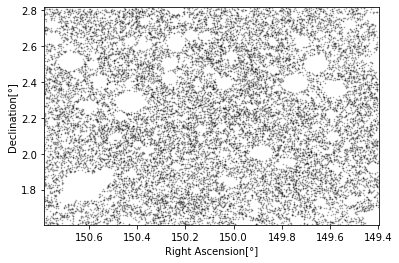

In [23]:
# Select a random subsample for sake of clarity
a = np.random.randint(0,nsrc,size=20000)
plt.scatter(cat['RA'][a],cat['DEC'][a],color='k',s=0.4,alpha=0.3)
plt.xlim(ramax,ramin)
plt.ylim(decmin,decmax)
plt.xlabel('Right Ascension[°]')
plt.ylabel('Declination[°]')
plt.show()

Redshift distributions and GzK diagram.
`lp_zp_2` is the secondary photoz solution in LePhare.
`lp_zq` is the photoz solution in LePhare using QSO/AGN templates. 

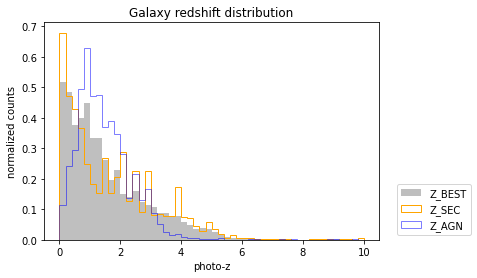

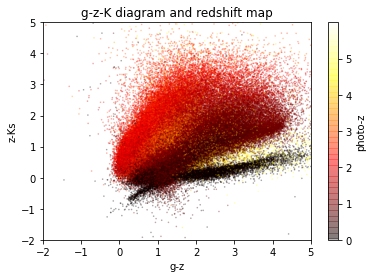

In [24]:
plt.hist(cat['photoz'],range=(0.01,10),log=False,bins=50,density=True,color ='grey',alpha=0.5,label = 'Z_BEST')
plt.hist(cat['lp_zp_2'],range=(0.01,10),log=False,bins=50,density=True,color ='orange',histtype='step',label = 'Z_SEC')
plt.hist(cat['lp_zq'][cat['lp_type']==2],range=(0.01,10),log=False,bins=50,density=True,color ='blue',alpha=0.5,label = 'Z_AGN',histtype='step')
plt.title('Galaxy redshift distribution')
plt.xlabel('photo-z')
plt.ylabel('normalized counts')
plt.legend(bbox_to_anchor=(1.04,0),loc='lower left') 
plt.show()

color1 = cat['HSC_g_MAG'] - cat['HSC_z_MAG']
color2 = cat['HSC_z_MAG'] - cat['UVISTA_Ks_MAG']
zmap = cat['photoz']
sel = (cat['photoz']>=0.) & (cat['photoz']<6.) & (cat['UVISTA_Ks_MAG']<24.5)
plt.scatter(color1[sel],color2[sel],c=zmap[sel],cmap='hot',s=0.4,alpha=0.3)
plt.xlim(-2,5)
plt.ylim(-2,5)
cbar=plt.colorbar()
cbar.set_label('photo-z')
plt.xlabel('g-z')
plt.ylabel('z-Ks')

plt.title('g-z-K diagram and redshift map')
plt.show()
    


Show the galaxy models from Bruzual & Charlot (2003) that have been used in *LePhare* to measure physical quantities. These are the basic (dust-free) templates in the rest-frame reference system, stored in an acillary file with HDF5 format. The instrinsic models are modified a-posteriori by adding redshift, dust attenuation, intervening IGM absorption. 

**Structure of the HDF5 file:** each BC03 model is a dataset (`/model1`,`/model2`, etc.) with a list of spectra (e.g., `/model1/spectra`) defined at the wavelength points stored in the attribute `lambda[AA]`. The number of spectra correspond to the number of ages stored in the attribute 'age' for each model dataset.

In [25]:
hdf = h5py.File("COSMOS2020_LePhare_v2_20210507_LIB_COMB.hdf5","r")

In [26]:
 def model_check(models,wvl,labels,title='SED templates (rest frame)'):
    
    """
    This function plots the SEDs (F_lambda vs lambda and F_nu vs lambda) 
    of the models specified by the user.    
    """
    # from a matplotlib colormap, create RGB colors for the figure
    cm = plt.get_cmap('gist_rainbow')
    cc = [cm(1.*i/len(labels)) for i in range(len(labels))]

    for i,f_lam in enumerate(models):
        plt.plot(wvl,f_lam,color=cc[i],label=labels[i]) # This will plot the flux lambda  
    plt.legend(bbox_to_anchor=(1.04,0),loc='lower left',ncol=3) 
    plt.title(title)
    plt.yscale('log') 
    plt.xscale('log')
    plt.xlim(800.,50000.) # focus on wvl range from UV to mid-IR
    plt.ylim(1e-14,1e-7)
    plt.xlabel('wavelength [Å]')
    plt.ylabel('Flux [erg/cm^2/s/Å]')
    plt.show()
    
    wvl *= u.AA # add units to ease conversion
    for i,f_lam in enumerate(models):
        f_lam *= u.erg/u.cm/u.cm/u.s/u.AA 
        f_nu = f_lam*(wvl**2)/const.c
        f_nu = f_nu.to(u.erg/u.cm/u.cm/u.s/u.Hz) 
        plt.plot(wvl,f_nu,color=cc[i],label=labels[i])
    plt.legend(bbox_to_anchor=(1.04,0),loc='lower left',ncol=3) 
    plt.title(title)
    plt.yscale('log') 
    plt.xscale('log')
    plt.xlim(800.,50000.)
    plt.ylim(1e-26,1e-18)
    plt.xlabel('wavelength [Å]')
    plt.ylabel('Flux [erg/cm^2/s/Hz]')
    plt.show()

    


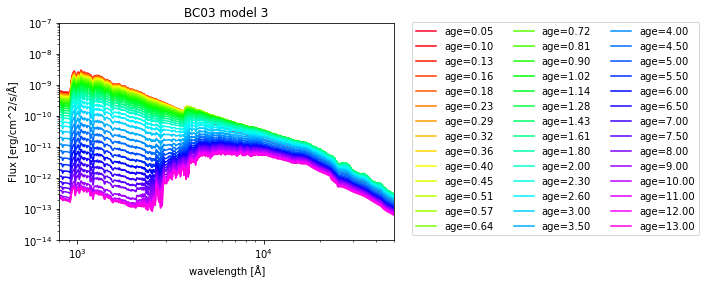

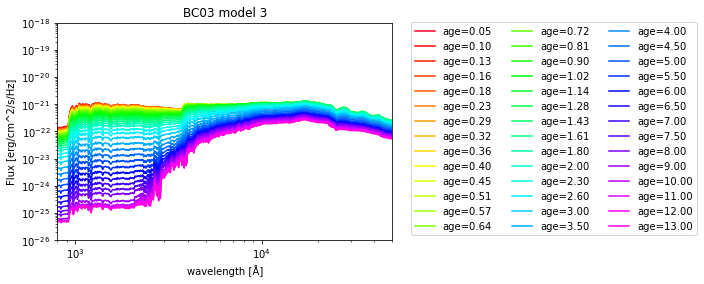

In [27]:
nmod = 3 # which model
model_check(hdf['/model{}/spectra'.format(nmod)],hdf['/model{}/spectra'.format(nmod)].attrs['lambda[AA]'],
            ['age={:.2f}'.format(i/1e9) for i in hdf['/model{}'.format(nmod)].attrs['age']],
           title='BC03 model {}'.format(nmod))

Show the observed SED of a given object, and overplot its BC03 template (after flux rescaling and dust attenuation). The template is the one resulting in the best fit (smallest $\chi^2$) according to *LePhare*. The SED fitting code takes also into account the absorption of intervening ISM and the flux contamination by strong nebular emission lines. However, for sake of simplicity, those two elements are not included here in the Notebook.  

To visualize *EAZY* templates, a different python script is available upon request to Gabriel Brammer ([contacts](https://gbrammer.github.io/))

In [28]:
# we need this to compute luminosity distances
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)  
# note that COSMOS2020 SED fitting assumes 'vanilla' cosmology

In [29]:
def dust_ext(w,law=0,ebv=0.):
    
    law1 = np.loadtxt("SB_calzetti.dat").T
    law2 = np.loadtxt("extlaw_0.9.dat").T
    ext_w = [law1[0],law2[0]]
    ext_k = [law1[1],law2[1]]
    if ebv>0.:
        k = np.interp(w,ext_w[law],ext_k[law])
        return np.power(10.,-0.4*ebv*k)
    else:
        return 1.
    

The COSMOS fitted model is model number 9
The offset applied is 865897.3785545913 and a redshift of 0.7233


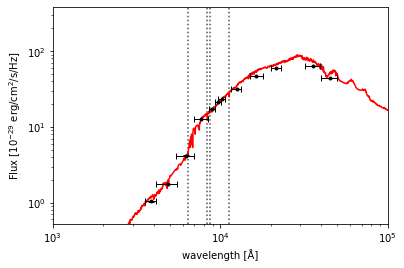

In [30]:
id_gal = 354321 # the ID number of the galaxy you want to plot
nid = np.where(cat['ID']==id_gal)[0][0]

wl_obs = np.array([filt_dict[i][0] for i in filt_use])  # wavelength center of the filter used 
wl_obserr = np.array([filt_dict[i][1] for i in filt_use])/2.
fnu_obs = np.array([cat[i+'_FLUX'][nid] for i in filt_use]) # Reads the measured magnitude at that wavelength
fnu_obserr = np.array([cat[i+'_FLUXERR'][nid] for i in filt_use]) #Magnitude associated +/-error
sel = fnu_obs>0.
if cat['{}_FLUX'.format(filt_use[0])].unit.to_string()=='uJy':
    plt.ylabel('Flux [$\mu$Jy]')
    plt.errorbar(wl_obs[sel],fnu_obs[sel],xerr=wl_obserr[sel],yerr=fnu_obserr[sel],fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
    ymin = min(fnu_obs[sel])*0.5
    ymax = max(fnu_obs[sel]+fnu_obserr[sel])*6
else: # assuming it's cgs
    plt.ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
    plt.errorbar(wl_obs[sel],fnu_obs[sel]*1e29,xerr=wl_obserr[sel],yerr=fnu_obserr[sel]*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
    ymin = min(fnu_obs[sel])*1e29*0.5
    ymax = max(fnu_obs[sel]+fnu_obserr[sel])*1e29*6
    
# Using the redshift of best-fit template
zp = cat['photoz'][nid] 
m = int(cat['lp_model'][nid])
wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA 
t = np.abs(hdf['/model{}'.format(m)].attrs['age']-cat['lp_age'][nid]).argmin()
flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA 
fnu_mod = flam_mod*(wvl**2)/const.c 
# Calculates the flux in units of [uJy] also applying dust ext
fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl.value,law=cat['lp_Attenuation'][nid],ebv=cat['lp_dust'][nid]) 
# Rescale the template
mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**cat['lp_mass_best'][nid]  # luminosity/mass resc
dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor
# Plot the best-fit model 
plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset,color='red',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
plt.vlines(3727*(1+zp),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
plt.vlines(5007*(1+zp),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
plt.vlines(4861*(1+zp),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
plt.vlines(6563*(1+zp),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 


plt.xscale('log')
plt.yscale('log')
plt.xlim(1000,100000) 
plt.ylim(ymin,ymax)
plt.xlabel('wavelength [Å]')


print("The COSMOS fitted model is model number",m)
print('The offset applied is',offset,'and a redshift of',zp)
plt.show()  

----------------------------
## Classic diagnostics

Also useful to learn what columns contain the galaxy physical quantities.
Columns for the *LePhare* version:
- Absolute magnitudes have the `lp_M` prefix followed by the filter name in capital letters (e.g., `lp_MI` for the *i* band).
- The most reliable stellar mass estimate is `lp_mass_med`, since it's the median of the PDF$(M_\ast)$; `lp_mass_best` is the $M_\ast$ of the best-fit template which is actually not the best to use.
- Simliarly to $M_\ast$, also the other physical quantities should be used in their `lp_{}_med` version (e.g., `lp_SFR_med`)

**WARNING:** the SFR estimates included in the COSMOS2020 catalogs have not been thoroughly tested, and are not recommended for high-level scientific projects. Nonetheless, they can be useful for sanity checks like in this case. 

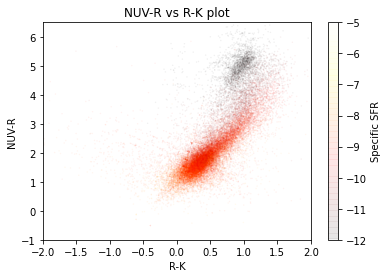

In [31]:
# Plot the NUV-r vs r-J diagram in a given z bin

zlow=0.5
zupp=0.8

# Cut the K magnitude at K<24 to remove noisy galaxies and stellar sequence
sel = (cat['UVISTA_Ks_MAG']<24) & (cat['photoz']<zupp) & (cat['photoz']>zlow) & (cat['lp_mass_med']>7)
catselec=cat[sel]

plt.scatter(catselec['lp_MR']-catselec['lp_MJ'],catselec['lp_MNUV']-catselec['lp_MR'],c=catselec['lp_SFR_med']-catselec['lp_mass_med'],s=0.3,alpha=0.05,cmap='hot',vmin=-12)
plt.clim(-5,-12)
clb = plt.colorbar()
clb.set_label('Specific SFR')
plt.ylim(-1,6.5)
plt.xlim(-2,2)
plt.xlabel('R-K')
plt.ylabel('NUV-R')
plt.title('NUV-R vs R-K plot')
plt.show()

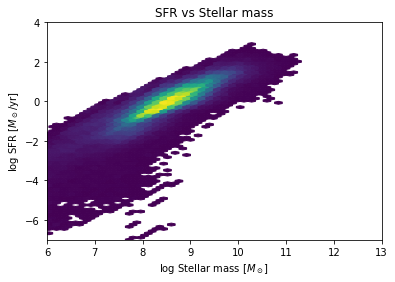

In [47]:
# Plot the SFR vs stellar mass diagram
# WARNING: the SFR estiimates from SED fitting without far-IR data (as in this case) are not particularly reliable, use them with caution
plt.hexbin(catselec['lp_mass_med'],catselec['lp_SFR_med'],gridsize=(50,50),extent=(5,13,-7,4),mincnt=5)
plt.ylim(-7,4)
plt.xlim(6,13)
plt.title('SFR vs Stellar mass')
plt.ylabel('log SFR [$M_\odot$/yr]')
plt.xlabel('log Stellar mass [$M_\odot$]')
plt.show()

--------------------------------------------------
## A simple machine learning application: GMM

Mixture models are probabilistic models that represent a number of subgroups within a population. **Gaussian mixture models (GMM)** do so by modelling the data set through a number of Gaussians (Duda et al., 1973). Its main assumption relies on the fact that all the data points within a certain data set can be generated from a mixture of a finite number of Gaussian distributions with unknown means and standard deviations. 

In this section we run the GMM algorithm on the COSMOS2020 galaxy sample, setting 4 Gaussian components that will divide the data in the same number of clusters (each data point being assigned to the cluster it has the most probability to belong to).

In [32]:
def mlinput(dat,colors,flux=False,cname="{}_MAG",verbose=True):
    """
    sominput(dat,colors,flux=False,cname="{}_MAG",verbose=True)

    This function helps preparing broad-band colors as input features 
    of a ML algorithm.

    Parameters
    ----------
    dat : NxM astropy.Table with M magnitudes (or fluxes) for N objects
    colors : list of str, each element is a pair of filters to compute colors (should be coherent with `dat` column names for filters)
    flux : bool, set to True if `dat` contains fluxes instead of magnitudes
    cname : str, format of the magnitude (or flux) column names
    verbose : bool, set to True to print out more info

    Output
    ------
    array to be used as input in ML applications; shape is N objects x M features
    """
    ngal = len(dat)
    ndim = len(colors)
    if verbose: print('\nDimensions of the param space:')
    datin = np.empty([ngal,ndim])
    # Prepare the colors
    for i,col in enumerate(colors): 
        col1 = cname.format(col[0]); col2 = cname.format(col[1])
        if verbose: print('dim#{} = '.format(i), col1,' - ',col2) #just a sanity check
        if flux: 
            datin[:,i] = -2.5*np.log10(dat[col1]/dat[col2])
            datin[:,i][(dat[col1]<0.)|(dat[col2]<0.)] = np.nan
        else: 
            datin[:,i] = dat[col1]-dat[col2]
            datin[:,i][(dat[col1]<0.)|(dat[col2]<0.)] = np.nan
    return datin

In [33]:
# Filters to use
filt_pick = ['CFHT_u','HSC_g','HSC_r','HSC_i','HSC_z','UVISTA_Y','UVISTA_J','UVISTA_H','UVISTA_Ks','IRAC_CH1']
# Colors to make
color_pick = [(filt_pick[i],filt_pick[i+1]) for i in range(len(filt_pick)-1)] # just use pair-wise colors (u-g, g-r, r-i, etc.)
# Create a parameter space of obs. fr. colors
color_in = mlinput(cat[cat['lp_type']==0],color_pick,flux=True,cname='{}_FLUX')


Dimensions of the param space:
dim#0 =  CFHT_u_FLUX  -  HSC_g_FLUX
dim#1 =  HSC_g_FLUX  -  HSC_r_FLUX
dim#2 =  HSC_r_FLUX  -  HSC_i_FLUX
dim#3 =  HSC_i_FLUX  -  HSC_z_FLUX
dim#4 =  HSC_z_FLUX  -  UVISTA_Y_FLUX
dim#5 =  UVISTA_Y_FLUX  -  UVISTA_J_FLUX
dim#6 =  UVISTA_J_FLUX  -  UVISTA_H_FLUX
dim#7 =  UVISTA_H_FLUX  -  UVISTA_Ks_FLUX


<ipython-input-32-395dace1d3ca>:29: RuntimeWarning: invalid value encountered in log10
  datin[:,i] = -2.5*np.log10(dat[col1]/dat[col2])


dim#8 =  UVISTA_Ks_FLUX  -  IRAC_CH1_FLUX


In [34]:
# Run the GMM algorithm
X = color_in[np.isfinite(color_in).all(axis=1)] # features
Xplus = cat[cat['lp_type']==0][np.isfinite(color_in).all(axis=1)]  # extra info (photoz etc)

gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(X)
labels = gmm.predict(X)
probs = gmm.predict_proba(X)
print(gmm.aic(X))  # print the Akaike Information Criterion (AIC)

4606959.491587451


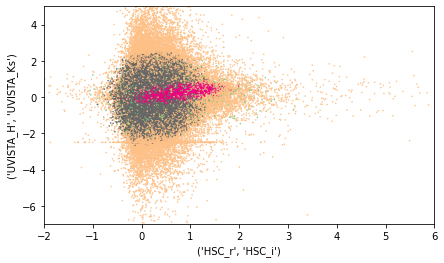

In [35]:
# Project the data in a color-color space, distinguishing the cluster classification
plt.figure(figsize=(7,4))
colA = 2; colB = -2
plt.scatter(X[:, colA], X[:, colB], c=labels, s=0.3, cmap='Accent');
plt.xlabel('{0}'.format(color_pick[colA]))
plt.ylabel('{}'.format(color_pick[colB]))
plt.xlim(-2,6)
plt.ylim(-7,5)
plt.show()

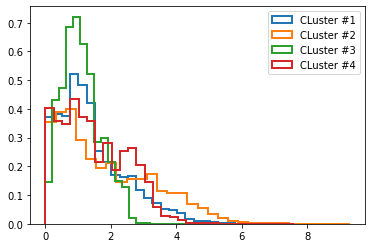

In [39]:
# Show the redshift distribution of the GMM clusters
for i in range(0,4):
    sel = labels==i
    catselec = Xplus[sel]
    plt.hist(catselec['photoz'],bins=30,density=True,histtype='step',linewidth=2,label='CLuster #{}'.format(i+1))
plt.legend(loc='upper right')
plt.show()

One of the main advantages of GMM is that the probabilistic description of the data distribution can be then used to create synthetic data samples. Although these "mock" samples do not have galaxy physical properties attached, they can be helpful for various tests (e.g. Monte Carlo extractions re-shuffling the photometry). 

In [40]:
# Create 3 synthetic "mocks" of 500 galaxies each
mocks = []
for i in range(3):
    modx = gmm.sample(n_samples=500)
    mocks.append(modx)

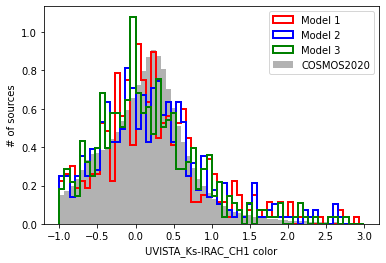

In [43]:
# Just visualize one color distribution
colA = 8

# the mocks
plt.hist(mocks[0][0][:,colA],bins=60,density=True,range=[-1,3],histtype='step',color='red',linewidth=2,alpha=1,label='Model 1')
plt.hist(mocks[1][0][:,colA],bins=60,density=True,range=[-1,3],histtype='step',color='blue',linewidth=2,alpha=1,label='Model 2')
plt.hist(mocks[2][0][:,colA],bins=60,density=True,range=[-1,3],histtype='step',color='green',linewidth=2,alpha=1,label='Model 3')

# and the original data
plt.hist(X[:,colA],bins=60,density=True,range=[-1,3],histtype='stepfilled',color='black',alpha=0.3,label='COSMOS2020')

plt.legend(loc='upper right')
plt.xlabel('{}-{} color'.format(color_pick[colA][0],color_pick[colA][1]))
plt.ylabel('# of sources')
plt.show()